**TESTING THE BASELINE MODEL**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

/content/drive/Shareddrives/Projeto DACO/scripts code


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight

# Dataloader
import import_ipynb
from dataloader import small_dataset
from sklearn import preprocessing


from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
###################### TESTING #####################

dataset_fold = 'windowing' # ['original', 'windowing']
model_selected = 'VGG' # ['VGG', 'ResNeXt']

print(f'Testing Mode using {dataset_fold} images')

################## PARAMETERS ##################

img_size = 224
BATCH_SIZE = 1

Testing Mode using windowing images


In [ ]:
import seaborn as sns

def evaluation_metrics (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1,2,3,4,5])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['epi','intrap','intrav','suba','subd', 'no'], yticklabels=['epi','intrap','intrav','suba','subd', 'no'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)

def evaluation_metrics_detect (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['no hemorrhage','hemorrhage'], yticklabels=['no hemorrhage','hemorrhage'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [ ]:
################## DATA LOADING AND MODEL ##################

# Data albumentations
aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)

class_weights_d = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4, 5], 
              y=detection_dataset['type'])

c_test_set = d_test_set[d_test_set['presence']==0] # only the images from the d_test_set with ICH

d_test_set, c_test_set = d_test_set.reset_index(drop=True), c_test_set.reset_index(drop=True)

d_test_set, c_test_set = small_dataset(d_test_set, dataset_fold, transforms), small_dataset(c_test_set, dataset_fold, transforms)

dtest = DataLoader(d_test_set, batch_size=BATCH_SIZE, shuffle=False) # This is the test set to be used in the pipeline (contains images with and without ICH)
ctest = DataLoader(c_test_set, batch_size=BATCH_SIZE, shuffle=False)

print ("\nLoaded \n")

# Model

if (model_selected == 'VGG'):
  model_classify = VGG16(num_classes=6)

model_classify.load_state_dict(torch.load(f'/content/drive/Shareddrives/Projeto DACO/scripts code/weights baseline + original/VGG_classification_latest_model_baseline.pth', map_location=torch.device('cpu')))
model_classify.to(device)

Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']

Loaded 



VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
###################### TEST #######################

true_labels_c = []
final_preds_c = []

sample_weights_c = []

model_classify.eval()


with torch.set_grad_enabled(False):
  
  for img, label_d, label_c in tqdm(dtest):
      img = img.to(device)
      
      true_labels_c.append(int(label_c.detach().numpy()))
      sample_weights_c.append(class_weights_d[int(label_c.detach().numpy())])

      label_pred = model_classify(img)

      y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)

      final_preds_c.append(int(y_pred.cpu().detach().numpy()))
      

100%|██████████| 1275/1275 [21:54<00:00,  1.03s/it]


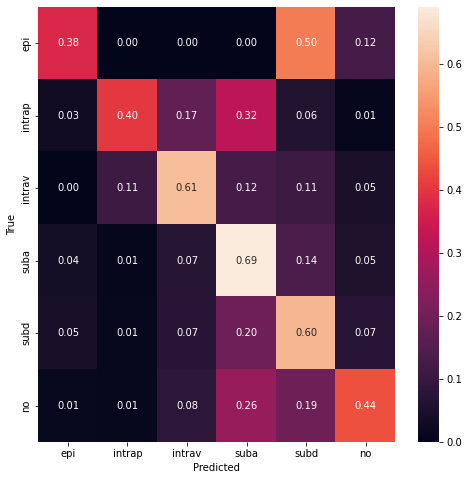

0.43160394862182344
0.7112776788994296
0.4949019607843137


In [ ]:
##################### EVALUATION ################################

evaluation_metrics(true_labels_c, final_preds_c)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

m_coef = matthews_corrcoef(true_labels_c, final_preds_c, sample_weight = sample_weights_c)
precision = precision_score(true_labels_c, final_preds_c, average = 'weighted')
recall = recall_score(true_labels_c, final_preds_c, average = 'weighted')

print(m_coef)
print(precision)
print(recall)